<a href="https://colab.research.google.com/github/fa7ih/surucuyorgunluk/blob/main/Swin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from timm import create_model
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
from PIL import Image
from google.colab import files

data_dir = '/content/dataset'
categories = ['Drowsy', 'NonDrowsy']

class CustomDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

all_filepaths = []
all_labels = []
for i, category in enumerate(categories):
    category_dir = os.path.join(data_dir, category)
    for filename in os.listdir(category_dir):
        filepath = os.path.join(category_dir, filename)
        all_filepaths.append(filepath)
        all_labels.append(i)  # Integer formatında kategoriler

kf = KFold(n_splits=3, shuffle=True, random_state=42)
all_metrics = []

class SwinModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(SwinModel, self).__init__()
        self.backbone = create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.backbone(x)

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss, accuracy, all_preds, all_labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(categories)

for fold, (train_index, val_index) in enumerate(kf.split(all_filepaths)):
    print(f"Fold {fold + 1}")

    train_filepaths = np.array(all_filepaths)[train_index]
    train_labels = np.array(all_labels)[train_index]
    val_filepaths = np.array(all_filepaths)[val_index]
    val_labels = np.array(all_labels)[val_index]

    train_dataset = CustomDataset(train_filepaths, train_labels, transform=transform)
    val_dataset = CustomDataset(val_filepaths, val_labels, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = SwinModel(num_classes=num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    num_epochs = 3
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy, val_preds, val_labels = validate(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    save_path = f'swin_model_fold_{fold + 1}.pth'
    torch.save(model.state_dict(), save_path)
    print(f"Model fold {fold + 1} olarak {save_path} dosyasına kaydedildi.")
    files.download(save_path)

In [ ]:
!pip install torch-xla==2.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 MB 6.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd

data = {
    'Fold': [1, 1, 1, 2, 2, 2, 3, 3, 3],
    'Epoch': [1, 2, 3, 1, 2, 3, 1, 2, 3],
    'Train Loss': [0.0399, 0.0120, 0.0054,
                   0.0320, 0.0120, 0.0072,
                   0.0377, 0.0118, 0.0012],
    'Val Loss': [0.0173, 0.0033, 0.0010,
                 0.0008, 0.0003, 0.0013,
                 0.0032, 0.0081, 0.0003],
    'Val Accuracy': [0.9942, 0.9990, 0.9996,
                     0.9998, 0.9999, 0.9995,
                     0.9996, 0.9976, 0.9999]
}

df = pd.DataFrame(data)

df.to_csv('/content/makine/dataframe.csv', index=False)


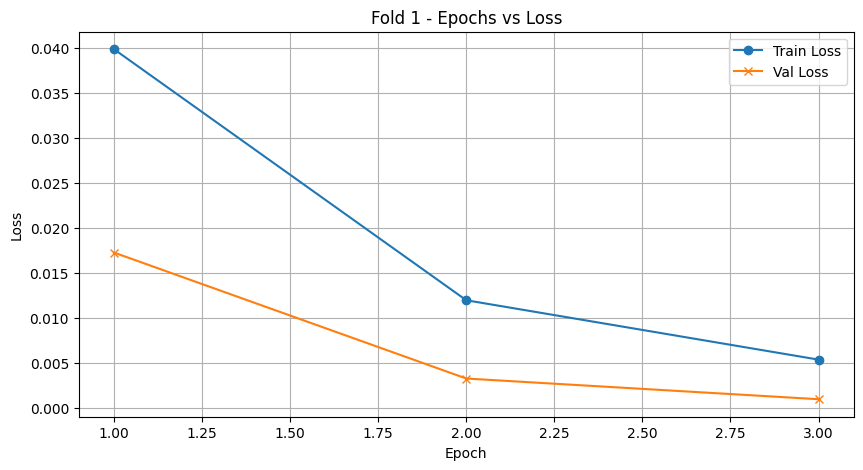

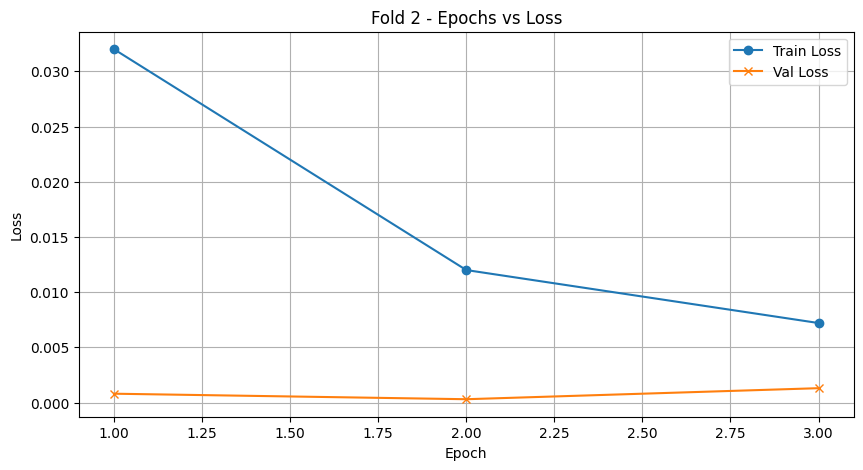

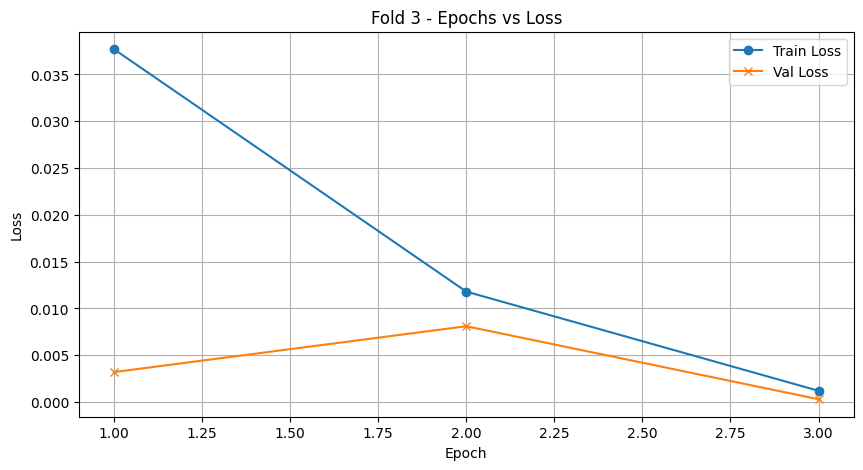

In [ ]:
import matplotlib.pyplot as plt

data = {
    'Fold': [1, 1, 1, 2, 2, 2, 3, 3, 3],
    'Epoch': [1, 2, 3, 1, 2, 3, 1, 2, 3],
    'Train Loss': [0.0399, 0.0120, 0.0054,
                   0.0320, 0.0120, 0.0072,
                   0.0377, 0.0118, 0.0012],
    'Val Loss': [0.0173, 0.0033, 0.0010,
                 0.0008, 0.0003, 0.0013,
                 0.0032, 0.0081, 0.0003],
    'Val Accuracy': [0.9942, 0.9990, 0.9996,
                     0.9998, 0.9999, 0.9995,
                     0.9996, 0.9976, 0.9999]
}
folds = sorted(set(data['Fold']))
for fold in folds:
    fold_data = {k: [v for i, v in enumerate(data[k]) if data['Fold'][i] == fold] for k in data}
    epochs = fold_data['Epoch']
    train_losses = fold_data['Train Loss']
    val_losses = fold_data['Val Loss']

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold} - Epochs vs Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
import os
from sklearn.model_selection import train_test_split

data_dir = '/content/dataset'

categories = ['Drowsy', 'NonDrowsy']

all_filepaths = []
all_labels = []

for i, category in enumerate(categories):
    category_dir = os.path.join(data_dir, category)
    for filename in os.listdir(category_dir):
        if filename.endswith(('jpg', 'png', 'jpeg')):
            filepath = os.path.join(category_dir, filename)
            all_filepaths.append(filepath)
            all_labels.append(i)


train_filepaths, test_filepaths, train_labels, test_labels = train_test_split(
    all_filepaths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

In [ ]:
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
import torchvision.transforms as transforms
from timm import create_model
import torch
import seaborn as sns
from PIL import Image
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
class CustomDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
def fix_state_dict_keys(state_dict):
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith("backbone."):
            new_key = key.replace("backbone.", "")  # Ön eki kaldır
            new_state_dict[new_key] = value
        else:
            new_state_dict[key] = value
    return new_state_dict



def load_model(model_path, num_classes, device):
    model = create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=num_classes)

    model = model.to(device)

    model.load_state_dict(torch.load(model_path, map_location=device),strict=False)

    return model

def plot_loss_graph(train_losses, val_losses):

    plt.figure(figsize=(8, 6))
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
def plot_confusion_matrix(labels, preds, fold=0):
    cm = confusion_matrix(labels, preds)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['NonDrowsy', 'Drowsy'], yticklabels=['NonDrowsy', 'Drowsy'])
    plt.title(f'Confusion Matrix (Fold {fold + 1})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
def plot_roc_curve(labels, probs, fold=0):
    fpr, tpr, thresholds = roc_curve(labels, probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (Fold {fold + 1})')
    plt.legend(loc='lower right')
    plt.show()
def calculate_metrics(labels, preds, probs):
    accuracy = accuracy_score(labels, preds)

    precision = precision_score(labels, preds, average="binary")

    recall = recall_score(labels, preds, average="binary")

    f1 = f1_score(labels, preds, average="binary")

    auc = roc_auc_score(labels, probs[:, 1])

    cm = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall (Sensitivity)": recall,
        "Specificity": specificity,
        "F1 Score": f1,
        "AUC": auc,
    }

    return metrics

def inference(model, dataloader, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

data_dir = '/content/dataset'

categories = ['Drowsy', 'NonDrowsy']

all_filepaths = []
all_labels = []

for i, category in enumerate(categories):
    category_dir = os.path.join(data_dir, category)
    for filename in os.listdir(category_dir):
        if filename.endswith(('jpg', 'png', 'jpeg')):
            filepath = os.path.join(category_dir, filename)
            all_filepaths.append(filepath)
            all_labels.append(i)

train_filepaths, test_filepaths, train_labels, test_labels = train_test_split(
    all_filepaths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

test_dataset = CustomDataset(test_filepaths, test_labels, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = '/content/swin_model_fold_3.pth'
model = load_model(model_path, num_classes=len(categories), device=device)

model_state_dict = torch.load(model_path, map_location=device)
fixed_state_dict = fix_state_dict_keys(model_state_dict)

model.load_state_dict(fixed_state_dict)
all_preds, all_probs, all_labels = inference(model, test_loader, device)

metrics = calculate_metrics(all_labels, all_preds, all_probs)
print("Metrics:", metrics)

plot_roc_curve(all_labels, all_probs, fold=0)
plot_confusion_matrix(all_labels, all_preds, fold=0)

if 'train_losses' in locals() and 'val_losses' in locals():
    plot_loss_graph(train_losses, val_losses)
else:
    print("Train and validation losses not available.")

print("Predictions:", all_preds[:10])
print("Probabilities:", all_probs[:10])
print("Labels:", all_labels[:10])



<ipython-input-7-6deccbd49fd9>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device),strict=False)
<ipython-inp